<a href="https://colab.research.google.com/github/faith-quant-lab/bible-scripting/blob/master/KJV_IDF_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faith NLP Tutorial 1. Word Importance via KJV

We show in this tutorial the concepts and techniques related to the automatic construction of concept importance.

## Import data
There are multiple ways of importing the KJV data into this Google Colab session. We decide on the simplest yet repeatable, of cloning from Github (for files under 25MB). Intermediate results will also be saved into github.

The KJV xml data is from http://www.crosswire.org/~dmsmith/kjv2006/


In [0]:
# use git as in 
# https://medium.com/@yuraist/how-to-upload-your-own-dataset-into-google-colab-e228727c87e9
! git clone https://github.com/weijingzhu/public_data.git

Cloning into 'public_data'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 19 (delta 0), reused 16 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [0]:
# Let's check that the file is indeed where we expect
!ls /content/public_data/faith/bible/crosswire_kjv_strong

kjvfull.xml  verse_df.pickle


We will be needing NLP libraries:

In [0]:
import pandas as pd
#!pip install -U spaCy
#!python -m spacy download en

In [0]:
# Test the package
import spacy
nlp = spacy.load('en')
doc = nlp('Hello     World!')
for token in doc:
    print('"' + token.text + '"', token.idx)
    
#create the processing function
def process(document):
    #create spacy object
    #spacy_doc = nlp(unicode(document)) #, parse=False, entity=False)
    spacy_doc = nlp(document)
    #grab the lemma for each token in the document
    processed_tokens = map(lambda token: token.lemma_ if token.lemma_ != '-PRON-' else 'we', spacy_doc)
    
    #join lemmas to a string
    result = " ".join(processed_tokens)
    return result

"Hello" 0
"    " 6
"World" 10
"!" 15


In [0]:
# indicate whether intermediate results are already available,
# and thus we can skip PART 1
import os
WORK_DIR = '/content/public_data/faith/bible/crosswire_kjv_strong/'
PART1_RESULT = 'verse_df.pickle'
if os.path.isfile(WORK_DIR + PART1_RESULT):
  print('Go ahead and skip to PART 2')
else:
  print("Need to run PART 1")

Go ahead and skip to PART 2


# PART 1. Data Processing
If the result of PART 1 already exists (check for the file verse_df.pickle above), then we can skip to PART 2 in subsequent runs.

## Process KJV+Strong data
Wikipedia: there are 929 chapters in the Old Testament. There are 260 chapters in the New Testament. This gives a total of 1,189 chapters (on average, 18 per book). Psalm 117, the shortest chapter, is also the middle chapter of the Bible, being the 595th Chapter.  KJV has 31,102 verses.

In [0]:
with open(WORK_DIR+'kjvfull.xml','r') as inFH:
  all_lines = inFH.readlines()

In [0]:
# how many lines: about the number of verses
len(all_lines)

34901

In [0]:
# peak at actual data
all_lines[15600:15610]

['<verse osisID="Ps.10.17" sID="Ps.10.17"/><w lemma="strong:H03068"><seg><divineName>Lord</divineName></seg></w>, <w morph="strongMorph:TH8804" lemma="strong:H08085">thou hast heard</w> <w lemma="strong:H08378">the desire</w> <w lemma="strong:H06035">of the humble</w>: <w morph="strongMorph:TH8686" lemma="strong:H03559">thou wilt prepare</w> <w lemma="strong:H03820">their heart</w>, <w lemma="strong:H0241">thou wilt cause thine ear</w> <w morph="strongMorph:TH8686" lemma="strong:H07181">to hear</w>:<note type="study">prepare: or, establish</note><verse eID="Ps.10.17"/>\n',
 '<verse osisID="Ps.10.18" sID="Ps.10.18"/><w morph="strongMorph:TH8800" lemma="strong:H08199">To judge</w> <w lemma="strong:H03490">the fatherless</w> <w lemma="strong:H01790">and the oppressed</w>, <w lemma="strong:H0582">that the man</w> <w lemma="strong:H0776">of the earth</w> <w morph="strongMorph:TH8686" lemma="strong:H03254">may no more</w> <w morph="strongMorph:TH8800" lemma="strong:H06206">oppress</w>.<note 

In [0]:
# look for other structures such as section information provided by KJV
all_lines[26620:26660]
# neither http://www.hackathon.bible/data.html
# or https://github.com/honza/bibles
# contains the section headings
# so we will have to crawl
# https://www.biblegateway.com/passage/?search=gen&version=ESV
# or temporarily specific the section portion for demo purpose
1

1

In [0]:
# Let's count the frequency of various types of tags at the start of lines
import collections

c = collections.Counter()
# count initial tag
for line in all_lines:
  toks = line.split(' ')
  c.update([ toks[0], ])
print(c)

Counter({'<verse': 30986, '<title': 1366, '<chapter': 1189, '</chapter>\n': 1189, '<div': 80, '</div>\n': 66, '': 18, '<?xml': 1, '<osis': 1, '<osisText': 1, '<header>\n': 1, '</header>\n': 1, '</osisText>\n': 1, '</osis>\n': 1})


### verse processing
The tag information confirms that the chapters begins and ends with "chapter" tags, and "div type='book'" tags will define the books.
Wiki says KJV has 31,102 verses. There are only 30986 "verse" tagged lines, so we need to identify the missing 116 verses.

Sporadic check shows that the missing 116 verses are due to a number of Psalms starts with "title type='psalm'" tags followed by verse 1.
So we have the rule for identifying the lines of the verses.

Note: every verse, chapter, and book are identified by the "osisid"

In [0]:
# rule for identifying verses
verses = [v for v in all_lines if v.startswith('<verse') or v.startswith('<title type="psalm"')]
len(verses)

31102

From the above glimpse of the raw data, we identify another problem with verse tag structure:

* the data uses non-standard "<verse startID /\>  verse-text <verse endID /\>"
* instead of standard XML tag structure "<verse\> verse-text <verse/\>"

so we will correct this to facilitate later processing, by use of regular expressions to convert these patterns.

In [0]:
# need to fix the verse structure
import re
VERSE_START_PATT = re.compile(r'(<verse [^\/]* sID=[^/]*)/>')
VERSE_START_TARGET = r'\1>'
VERSE_END_PATT = re.compile(r'<verse eID=[^\/]*/>')
VERSE_END_TARGET = '</verse>'

def fixverse(v):
    if v.startswith('<verse') or v.startswith('<title type="psalm"'):
        w = re.sub(VERSE_START_PATT, VERSE_START_TARGET, v)
        x = re.sub(VERSE_END_PATT, VERSE_END_TARGET, w) 
        return x
    else:
        return v
      
# Apply the fix 
fixverse_lines = [fixverse(x) for x in all_lines]

### remove titles , notes
One more thing we notice is that there are tags for titles and notes, which are not part of the bible but added for the reader's convenience. 

We will remove these text, by the tool BeautifulSoup, which parses xml structures and allow us to replace tags easily. 

We will replace the title and notes with empty tags with no text.

In [0]:
from bs4 import BeautifulSoup
bible_xml = ''.join(fixverse_lines)
soup= BeautifulSoup(bible_xml)

# print(soup.findAll('div', type='book')[33])
# shows:
# <note type="study">God…: or, The <divinename>Lord</divinename> is a jealous God, and a revenger, etc</note>

new_tag = soup.new_tag("note")
new_tag.string = ""

for t in soup.findAll('note'):
    t.replace_with(new_tag)
    
new_tag = soup.new_tag("title")
new_tag.string = ""

for t in soup.findAll('title'):
    t.replace_with(new_tag)    
    
# soup now contains cleaned-up xml

### Corpus = Book/Chapter/Verse-level Document
Next we will construct a corpus of documents from the KJV text. We will consider 3 definition of "document"

* book-level
* chapter-level
* verse-level

We will represent the corpus of documents by the Pandas DataFrame object.

In [0]:
# A common constructor of a corpus DataFrame, when input a list of documents
def doc_df(doclist):
    osisid = [doc.get('osisid') for doc in doclist]
    doc_text = [doc.text for doc in doclist]
    index = range(len(osisid))
    
    return pd.DataFrame({
        'osisid': osisid,
        'text': doc_text,
    }, index=index)

verse_docs = soup.findAll('verse')
verse_df = doc_df(verse_docs)

chap_docs = soup.findAll('chapter')
chap_df = doc_df(chap_docs)

book_docs = soup.findAll('div', type='book')
book_df = doc_df(book_docs)

In [0]:
# we can access individual documents by a range or by loc
print(verse_df[17:18])
print()
# or
print(verse_df.loc[17])
#
# but cannot do the ambiguous
# verse_df[17]


      osisid                                               text
17  Gen.1.18  And to rule over the day and over the night, a...

osisid                                             Gen.1.18
text      And to rule over the day and over the night, a...
Name: 17, dtype: object


### tokenization of text
Instead of the raw text (with capitalization, punctuation, etc), we will be working with cleaned-up linguistic tokens.

This will be done by the SpaCy package. 

Furthermore, we dont want to redo this task for verse_df, chapter_df, and book_df, so we will just perform token processing for verse_df, and rebuild the chapter_df and book_df based on the verse_df, and using just the lemma (tokens) instead of the raw text.

In [0]:

# add lemma as a new column in our verse-DataFrame
verse_df['lemma'] = verse_df['text'].apply(process)

In [0]:
# create the book and chapter id based on the verse-id.
def getBookId(dot3):
    return dot3.split('.')[0]

def getChapId(dot3):
    parts = dot3.split('.')
    return ".".join(parts[:2])
  
verse_df['book_id'] = verse_df['osisid'].apply(getBookId)
verse_df['chap_id'] = verse_df['osisid'].apply(getChapId)


In [0]:
# This is a good Save Point
import pickle
pickle.dump( verse_df, open( WORK_DIR + PART1_RESULT, "wb" ) )

# PART 2. Interpretation

In [0]:
# If skipped PART 1, then run this to load verse_df and continue
import pickle
verse_df = pickle.load( open( WORK_DIR + PART1_RESULT, "rb" ) )

In [0]:
# Now we can paste together the verse_lemma into chapter and book objects
chap_lemma_df = (verse_df.groupby('chap_id')['lemma']).apply(" ".join)
# let's look at typical lengths of these objects
chap_lemma_df.apply(len)[:10]

chap_id
1Chr.1     3997
1Chr.10    1913
1Chr.11    5141
1Chr.12    5288
1Chr.13    1980
1Chr.14    1916
1Chr.15    3875
1Chr.16    4474
1Chr.17    3976
1Chr.18    2278
Name: lemma, dtype: int64

In [0]:
# same for constructing the book-level dataframe
book_lemma_df = (verse_df.groupby('book_id')['lemma']).apply(" ".join)
book_lemma_df.apply(len)[:10]

book_id
1Chr      110525
1Cor       48764
1John      12736
1Kgs      125610
1Pet       13191
1Sam      127897
1Thess      9502
1Tim       12514
2Chr      135888
2Cor       31563
Name: lemma, dtype: int64

## Word occurrence, Term Frequency and IDF
For each corpus, we can compute the Document Term-frequency Matrix (DTM) and also the Inverse Document Frequency.

Vectorizer refs:
* [Textacy](https://chartbeat-labs.github.io/textacy/getting_started/quickstart.html#make-a-corpus://)
* [sklearn vectorizer](https://towardsdatascience.com/hacking-scikit-learns-vectorizers-9ef26a7170af://)


In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Normally we would pass in the "process" function to sklearns vectorizer
# as a preprocessing step
# but now we already have that in the lemma column of our DataFrame
#
#toDTM = CountVectorizer(preprocessor=process)
#chap_DTM = toDTM.fit_transform(chapters_text).todense()
#
#vectorizer = TfidfVectorizer(preprocessor=process, stop_words=None)
#dtm = vectorizer.fit_transform(chapters_text).todense()

def compute_vectorizer(docs):
    toDTM = CountVectorizer()
    vectorizer = TfidfVectorizer(stop_words=None)

    DTM = toDTM.fit_transform(docs).todense()
    idf = vectorizer.fit_transform(docs).todense()
    words = toDTM.get_feature_names()

    # add a DTM where "the" is normalized to 100
    # but for verse-level, if TF(the)=0 or 1, and TF(faith)=3, then it will dominate as 300
    idx_the = words.index('the')
    # avoid zero-divider
    col_the = DTM[:,idx_the]+1.0
    DTM_the = (DTM/col_the)*100.0
    
    result = {
        'DTM':DTM,
        'DTM_the':DTM_the,
        'IDF':idf,
        'words':words, # vocabulary
        'toDTM':toDTM, #Count_Vectorizer
        'vectorizer':vectorizer #TFIDF_vectorizer
    }
    #
    #If the corpus is small, we can visually see the document matrix
    #summary = pd.DataFrame(toDTM, columns = verse_voc, index = documents).astype(float)
    #
    return result

    
# Apply to verse-level
verse_docs = verse_df['lemma'].tolist() 
verse_result = compute_vectorizer(verse_docs)

len(verse_result['words'])
# 9979 for text
# 10067 for lemma

10067

In [0]:
chap_lemma_df[:3]

chap_id
1Chr.1     adam , sheth , enosh , kenan , mahalaleel , je...
1Chr.10    now the philistines fight against israel ; and...
1Chr.11    then all israel gather we to david unto hebron...
Name: lemma, dtype: object

In [0]:
# Apply to chapter-level
chap_result = compute_vectorizer(chap_lemma_df)

len(chap_result['words'])

10067

In [0]:
# Apply to book-level
book_result = compute_vectorizer(book_lemma_df)

len(book_result['words'])


10067

In [0]:
# Explore how to get a normalized DTM so that "the" has same TF in all docs
idx_the = book_result['words'].index('the')
col_the = book_result['DTM'][:,idx_the]+0.001
100*book_result['DTM']/col_the
#book_result['DTM']


matrix([[0.69930037, 0.09324005, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

### Interpretation of IDF result by example


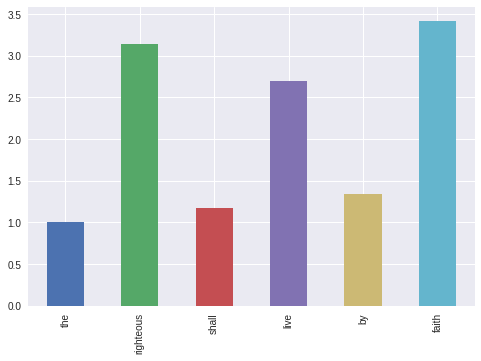

In [0]:
import matplotlib.pyplot as plt
# DEMO
query1 = "The righteous shall live by faith."

def get_sentence_idfs(idf_model, sentence, preproc_needed=True):
    if preproc_needed:
        words_in_query = process(sentence).split(" ")
    else:
        #sentence is already in lemma form
        words_in_query = sentence.split(" ")
    # filter out-of-vocabulary
    seen_words = [w for w in words_in_query if w in idf_model['words']]
    # get idf
    idx = [idf_model['words'].index(i) for i in seen_words]
    idf_values = [idf_model['vectorizer'].idf_[i] for i in idx]
    return (idf_values, seen_words)
  
def show_query_idf(idf_model, query):
    #grab the idf values of words in the query
    (idf_values, seen_words) = get_sentence_idfs(idf_model, query)
    
    #plot the idf values for each word
    ax = pd.Series(idf_values, index = seen_words).plot(kind = 'bar')
    plt.show()
    ax.grid()
    
show_query_idf(chap_result, query1)

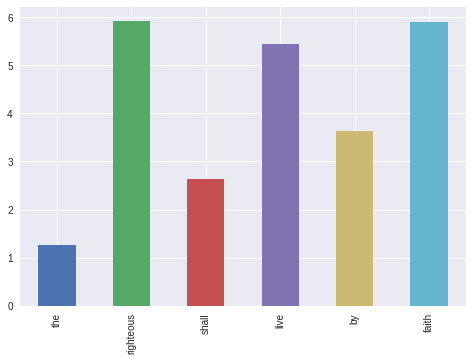

In [0]:
show_query_idf(verse_result, query1)

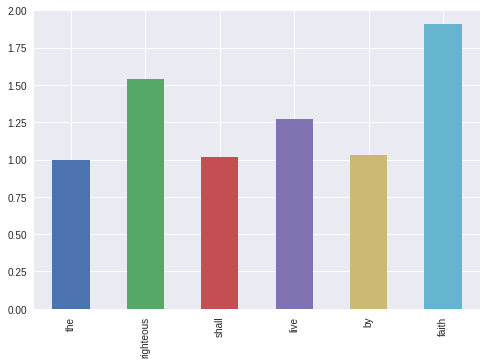

In [0]:
show_query_idf(book_result, query1)

#### Observations on document definition
* The range (max IDF) is defined by log(N), so verse-level has the largest N, book-level IDF has the least N.
* The key is the relative variation among words.
* On the book level, most words would appear, and thus less distinction among words when using book-IDF
* Verses are shortest documents, containing less words, so the verse-IDF variations would emphasize the frequent words, such as stopwords. Meaningful words will appear over multiple documents and their IDF variations will be high but relatively similar. 

Conclusion: using the Chapter-level IDF will give the best balance, with emphasis on meaningful words, while not neglecting the frequent words.

### Sentence importance via average IDF
Let us consider taking the mean IDF of words in a sentence. (Sum of IDF would vote for longer sentences)
we can use Mean(top60% words) so that the bottom 40% dropped will be used mostly by stopwords. This may slightly favor longer sentences.

We should test with a chapter or a short book first, since the processing is slow.
We will definitely save the computed values for this stage.

In [0]:
import numpy as np

def sent_mean_idf(sent_lemma, mean_top_pct=100, idf_model=verse_result):
    # mean_top_pct: if negative value, it means to use absolute length    
    preproc_flag = False
    (idf_values, seen_words) = get_sentence_idfs(idf_model, sent_lemma, preproc_flag)
    
    if mean_top_pct < 100:
        idf_values_sorted = sorted(idf_values)
        if mean_top_pct < 0:
            used_values = len(seen_words)+mean_top_pct
            if used_values < 0:
                used_values = 0
        else:
            used_values = int(len(seen_words)*(100-mean_top_pct)/100.0)
        return np.mean(idf_values_sorted[used_values :])
    else:
        return np.mean(idf_values)
      
#very long processing
#verse_df['verse_IDF1'] = verse_df['lemma'].apply(sent_mean_idf)

Applying these computation to the entire bible may take some time.  

Since we are still at the exploratory stage, we can test our algorithms on just one book of the Bible.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


-0.15950684772101073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


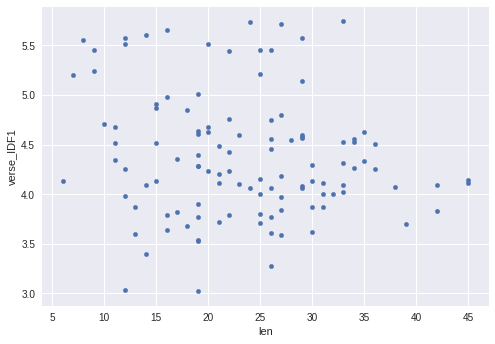

In [0]:
# let's create a short test data
t1 = verse_df[verse_df['book_id']=='1Tim']

# add a column of pretty text that includes the verse number
t1['ptext']=t1['osisid']+t1['text']
t1['len']=t1['lemma'].apply(lambda x: len(x.split(" ")))

t1['verse_IDF1'] = t1['lemma'].apply(sent_mean_idf)

print(t1['len'].corr(t1['verse_IDF1']))
#shows -0.15950684772101073
t1.plot.scatter(x='len', y='verse_IDF1')

In [0]:
t1.sort_values('verse_IDF1')['ptext'].apply(print)

1Tim.2.4Who will have all men to be saved, and to come unto the knowledge of the truth.
1Tim.4.5For it is sanctified by the word of God and prayer.
1Tim.6.15Which in his times he shall shew, who is the blessed and only Potentate, the King of kings, and Lord of lords;
1Tim.2.3For this is good and acceptable in the sight of God our Saviour;
1Tim.1.14And the grace of our Lord was exceeding abundant with faith and love which is in Christ Jesus.
1Tim.2.5For there is one God, and one mediator between God and men, the man Christ Jesus;
1Tim.1.2Unto Timothy, my own son in the faith: Grace, mercy, and peace, from God our Father and Jesus Christ our Lord.
1Tim.5.7And these things give in charge, that they may be blameless.
1Tim.3.5(For if a man know not how to rule his own house, how shall he take care of the church of God?)
1Tim.4.16Take heed unto thyself, and unto the doctrine; continue in them: for in doing this thou shalt both save thyself, and them that hear thee.
1Tim.2.14And Adam was not 

29720    None
29752    None
29803    None
29719    None
29710    None
29721    None
29698    None
29770    None
29736    None
29763    None
29730    None
29795    None
29746    None
29697    None
29751    None
29708    None
29743    None
29772    None
29704    None
29738    None
29707    None
29790    None
29761    None
29789    None
29783    None
29757    None
29764    None
29717    None
29769    None
29791    None
         ... 
29802    None
29785    None
29756    None
29727    None
29709    None
29732    None
29799    None
29742    None
29782    None
29760    None
29809    None
29715    None
29800    None
29766    None
29793    None
29778    None
29739    None
29700    None
29808    None
29729    None
29702    None
29786    None
29794    None
29726    None
29733    None
29749    None
29754    None
29792    None
29734    None
29725    None
Name: ptext, Length: 113, dtype: object

#### Observations based on [1 Timothy 2](https://www.biblegateway.com/passage/?search=1+Timothy+2&version=KJV):
* low IDF 1Tim2.3, 1Tim2.4:  use simple words
* high IDF 1Tim2.9, 1Tim2.10: use rarer words
* IDF reflects only the simplicity or complexity of words, and not the theological importance
* (for sentence centrality we will need Verse Proximity Network approach)
* we can instead use the IDF to grade how simple a sentence would be for memory

-0.049998765101792464


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


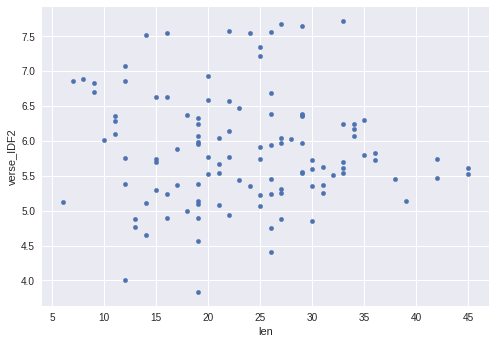

In [0]:
# IDF2 attempt: use top 60% of the words
t1['verse_IDF2'] = t1['lemma'].apply(lambda x:sent_mean_idf(x, mean_top_pct=60))
print(t1['len'].corr(t1['verse_IDF2']))
#shows -0.1352419300459481
t1.plot.scatter(x='len', y='verse_IDF2')

In [0]:
t1.sort_values('verse_IDF2')['ptext'].apply(print)

1Tim.2.4Who will have all men to be saved, and to come unto the knowledge of the truth.
1Tim.4.5For it is sanctified by the word of God and prayer.
1Tim.6.15Which in his times he shall shew, who is the blessed and only Potentate, the King of kings, and Lord of lords;
1Tim.2.5For there is one God, and one mediator between God and men, the man Christ Jesus;
1Tim.2.3For this is good and acceptable in the sight of God our Saviour;
1Tim.3.5(For if a man know not how to rule his own house, how shall he take care of the church of God?)
1Tim.5.7And these things give in charge, that they may be blameless.
1Tim.4.16Take heed unto thyself, and unto the doctrine; continue in them: for in doing this thou shalt both save thyself, and them that hear thee.
1Tim.1.2Unto Timothy, my own son in the faith: Grace, mercy, and peace, from God our Father and Jesus Christ our Lord.
1Tim.5.20Them that sin rebuke before all, that others also may fear.
1Tim.2.14And Adam was not deceived, but the woman being decei

29720    None
29752    None
29803    None
29721    None
29719    None
29736    None
29770    None
29763    None
29698    None
29783    None
29730    None
29710    None
29772    None
29795    None
29697    None
29751    None
29764    None
29745    None
29758    None
29743    None
29746    None
29738    None
29708    None
29704    None
29761    None
29757    None
29722    None
29717    None
29807    None
29789    None
         ... 
29715    None
29800    None
29796    None
29742    None
29748    None
29713    None
29797    None
29780    None
29732    None
29731    None
29760    None
29809    None
29709    None
29778    None
29729    None
29726    None
29766    None
29794    None
29786    None
29702    None
29700    None
29793    None
29749    None
29754    None
29734    None
29808    None
29739    None
29733    None
29792    None
29725    None
Name: ptext, Length: 113, dtype: object

0.6704999726142302


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


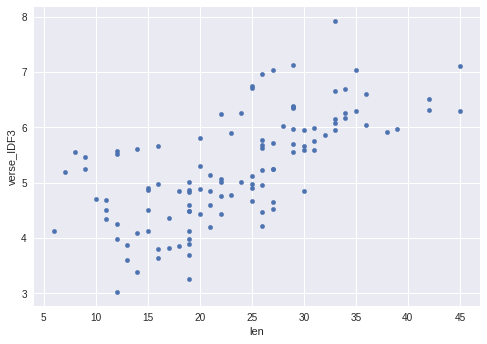

In [0]:
# IDF3 attempt: use top 15 of the words
t1['verse_IDF3'] = t1['lemma'].apply(lambda x:sent_mean_idf(x, mean_top_pct=-15))
print(t1['len'].corr(t1['verse_IDF3']))
#shows -
t1.plot.scatter(x='len', y='verse_IDF3')
#t1.sort_values('verse_IDF3')['text'].apply(print)

0.9564411294633034


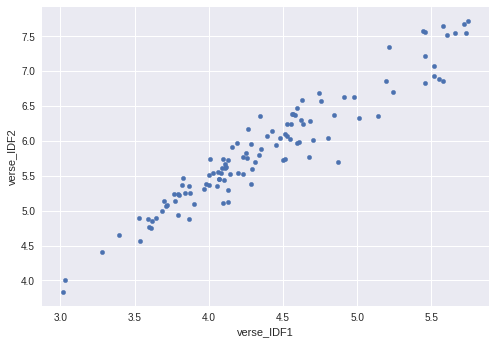

In [0]:
print(t1['verse_IDF1'].corr(t1['verse_IDF2']))
t1.plot.scatter(x='verse_IDF1', y='verse_IDF2')

0.5658203925130009


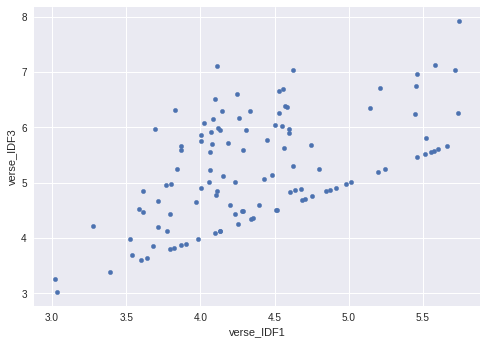

In [0]:
print(t1['verse_IDF1'].corr(t1['verse_IDF3']))
t1.plot.scatter(x='verse_IDF1', y='verse_IDF3')

0.4654173160227051


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


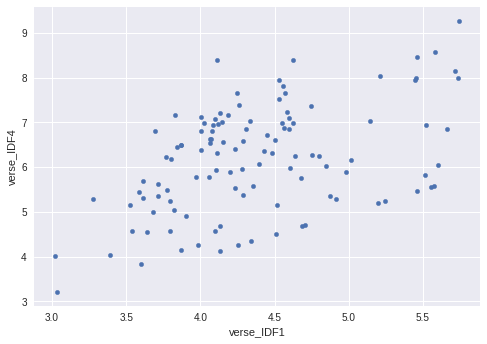

In [0]:
# IDF4 attempt: use top 10 of the words
t1['verse_IDF4'] = t1['lemma'].apply(lambda x:sent_mean_idf(x, mean_top_pct=-10))
print(t1['verse_IDF1'].corr(t1['verse_IDF4']))
t1.plot.scatter(x='verse_IDF1', y='verse_IDF4')


In [0]:
t1.corr()
# IDF1 = mean(all)
# IDF2 = mean(top60%)
# IDF3 = mean(top15)
# IDF4 = mean(top10)


,len,verse_IDF1,verse_IDF2,verse_IDF3,verse_IDF4
len,1.000000,-0.159507,-0.049999,0.670500,0.727134
verse_IDF1,-0.159507,1.000000,0.956441,0.565820,0.465417
verse_IDF2,-0.049999,0.956441,1.000000,0.642881,0.584292
verse_IDF3,0.670500,0.565820,0.642881,1.000000,0.933712
verse_IDF4,0.727134,0.465417,0.584292,0.933712,1.000000


#### Observations on variation of topN
* average of all values is anticorrelated with length: the longer the sentence, the more likely of lower value words to dominate. i.e. every additional word is likely to be of lower IDF value.
* hence having just the top 60% shows less anticorrelation.
* top15 and top10 will correlate with length, as having more words will give more chance for the topK to achieve higher value.
* Mean(All) correlates with top60%, top15 and top10 in decreasing order, since fewer words are being correlated.
* top60% and top15 are the "border" candidates of the two cluster of behaviors (the topPercent vs topK)
* qualitatively none of these variations show great difference from our observation and conclusion

### using Document Term Frequency
Inverse Document Frequency (IDF) cleverly summarizes the importance of words by considering how many documents the word appear in.
We have the entire Document Term Frequency (TF) matrix (DTM), detailing how many times a word appear in each document.
Effectively IDF disregards or treats the TF in each doc as a constant (1 or 0). (Of course, the vector space model will eventually use TFxIDF which will use the TF information.)

Surely we can make use of the TF and extract more meaning. For example:
* From DTM we can compute word self-correlation within a document or nearby documents. 
* Tokens with large IDF may be rare word or random typos. Error words would appear infrequently in few documents, and appear rarely in each. Contentful words would have higher occurrence within a document.
* T-stat of the collection of TFs is shown to be useful (quote paper)




In [0]:
# we will use book_DTM as small matrix for exploration
print(book_result['DTM'].shape)
# (66, 10067)
print(type(book_result['DTM']))
#numpy.matrixlib.defmatrix.matrix

tmplist = book_result['DTM'][:,17].flatten()
#tmplist[tmplist!=0].mean()
tmplist[tmplist!=0].std()

(66, 10067)
<class 'numpy.matrixlib.defmatrix.matrix'>


1.7399263633843818

In [0]:
def compute_TF_tstat_for_word(w, tf_model):
    voc = tf_model['words']
    result = {
        'N' : 0,
        'max' : 0,
        'min' : 0,
        'mean' : 0,
        'std' : None,
        'tstat' : None
    }
    if w not in voc:
        return result
    wid = voc.index(w)
    # document term-freq matrix
    dtm = tf_model['DTM_the']
    tf_list_with_zeros = dtm[:, wid].flatten()
    tf_list = tf_list_with_zeros[tf_list_with_zeros!=0]
    result['N'] = tf_list.size
    result['mean'] = tf_list.mean()
    result['max'] = tf_list.max()
    result['min'] = tf_list.min()
    
    if tf_list.size < 2:
        # not enough for std
        return result
    result['std'] = tf_list.std()
    if result['std'] > 0:
        result['tstat']  = result['mean']/result['std']
    
    return result
    

In [0]:
pd.set_option('precision', 2)

def dtm_stats_df(query, model_result):
    df_model = None
    for w in query:
        # hacky way to convert dict to a dataframe
        df = pd.DataFrame(pd.Series(compute_TF_tstat_for_word(w, model_result)), columns=[w]).transpose()
        if df_model is None:
            df_model = df
        else:
            df_model = df_model.append(df)
    return df_model

test_sent = 'the righteous shall live by faith god jehovah elohim jesus abraham david ruth'
test_words = test_sent.split(' ')

In [0]:
#Add the corresponding IDF as a column to the Stat DF

for model_res in [book_result, chap_result, verse_result]:
    stat_DF = dtm_stats_df(test_words, model_res)
    #add IDF as a column: first turn IDF result into a DF object
    (idf,words)=get_sentence_idfs(model_res, test_sent, preproc_needed=False)
    idf_DF = pd.DataFrame.from_dict({'idf':idf,'index':words}).set_index('index')
    result = pd.concat([stat_DF, idf_DF], axis=1)
    print(result)
    print('-'*80)

              N    max   mean    min    std  tstat   idf
abraham    27.0   5.45   0.78   0.03   1.28   0.61  1.87
by         64.0  20.54   5.90   0.78   4.44   1.33  1.03
david      28.0  17.56   2.20   0.09   4.33   0.51  1.84
elohim      0.0   0.00   0.00   0.00    NaN    NaN   NaN
faith      26.0  17.43   5.18   0.05   4.79   1.08  1.91
god        64.0  45.88  11.29   0.38   9.74   1.16  1.03
jehovah     5.0   0.07   0.05   0.03   0.01   4.05  3.41
jesus      26.0  43.75  11.33   1.33   8.80   1.29  1.91
live       50.0   5.41   1.11   0.11   1.08   1.03  1.27
righteous  38.0   4.64   0.79   0.03   1.06   0.75  1.54
ruth        2.0   7.89   3.98   0.07   3.91   1.02  4.11
shall      65.0  44.55  14.38   1.08  10.93   1.32  1.02
the        66.0  99.97  99.32  93.75   1.22  81.57  1.00
--------------------------------------------------------------------------------
                N     max   mean    min    std  tstat   idf
abraham      76.0   53.33   7.53   0.93  11.42   0.66  3.74
b

#### Interpretation
* On whatever level, most words' minimum nonzero occurrence is 1. (Only stopwords like "the" will have larger minimum on the book level)
* On verse level, the mean TF of most words is near 1. The max will be limited by sentence length. So the TF occurrence are clustered around 1, and thus the key driver for STD and TSTAT is the N (representing the number of nonzero TF documents) which enters standard error as a 1/sqrt(N). We should therefore expect tstat to be correlated with IDF which varies as log(1/N).
* The statistics in book and chapter level indicate that the variation of TF is really driven by the length of the books. So if we want meaningful t-stats, we should use percentage Term Frequency instead.


### Application of IDF and TSTAT
* use these as dimensions/features for word clustering
* let us see what clusters we will get


## Kishore's word gain

## Latest research result on word meaning


## Apply NLU to Strong numbers

In [0]:
# need to extract osisID into Chapter number, for 2 types of patterns
verses[15506:15511]

['<verse osisID="Ps.99.7" sID="Ps.99.7"/><w morph="strongMorph:TH8762" lemma="strong:H01696">He spake</w> <w lemma="strong:H06051">unto them in the cloudy</w> <w lemma="strong:H05982">pillar</w>: <w morph="strongMorph:TH8804" lemma="strong:H08104">they kept</w> <w lemma="strong:H05713">his testimonies</w>, <w lemma="strong:H02706">and the ordinance</w> <transChange type="added">that</transChange> <w morph="strongMorph:TH8804" lemma="strong:H05414">he gave</w> them.<verse eID="Ps.99.7"/>\n',
 '<verse osisID="Ps.99.8" sID="Ps.99.8"/><w morph="strongMorph:TH8804" lemma="strong:H06030">Thou answeredst</w> <w lemma="strong:H03068">them, O <seg><divineName>Lord</divineName></seg></w> <w lemma="strong:H0430">our God</w>: <w lemma="strong:H0410">thou wast a God</w> <w morph="strongMorph:TH8802" lemma="strong:H05375">that forgavest</w> <w morph="strongMorph:TH8802" lemma="strong:H05358">them, though thou tookest vengeance</w> <w lemma="strong:H05949">of their inventions</w>.<verse eID="Ps.99.8"

# PART 3. Application to Memory Verse scoring

see separate [notebook](https://colab.research.google.com/drive/1ImuZIOIIxcXmzv8RPoEpJ8FHqImN6bvX).